In [1]:
#import things we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import seaborn as sns
from scipy.stats import zscore
set_metric='euclidean'
#import warnings
#warnings.filterwarnings("ignore")
#calc_proj_dens_sorted.to_csv('allen_connectivities')
ISH_data_raw=pd.read_csv('data/AllGeneExpression_unprocessed.csv')
ISH_data_list=pd.read_csv('mouse_abi_tool-master/data/aba/mouse_expression_data_sets.csv')

In [2]:
uniq_colors=['mediumorchid','gray','royalblue','darkred','red','hotpink',
             'khaki','palegreen','seagreen','orange','lavender',
             'steelblue','navy','dodgerblue','thistle','violet',
             'deeppink','pink','slateblue','peru','darkorange',
             'magenta','cyan','lightcoral','lawngreen',
             'burlywood'] # to use later

In [3]:
ISH_data_raw.rename(columns={"Unnamed: 0": "brain_region"},inplace=True)
#format:  gene.P.RP_

In [4]:
node_input =['PL', 'ILA', 'ORB', 'GU', 'AI', 'MOs', 'MOp','GPe','GPi','STRd','PALv',
             'BST','MEA', 'AAA', 'NLOT', 'COA', 'BMA', 'NDB','PVH','LH','MH','CEA',
             'LHA','ZI','DR','PAG','LDT','PB','CBN','ACB','LPO','MPO','MS','LSX','MA','EPv']
len(node_input)

36

In [5]:
#testing - delete this cell later
node_input =['PL', 'ILA', 'ORB', 'GU', 'AI', 'MOs', 'MOp','GPe','GPi','STRd','PALv',
             'BST','MEA', 'AAA', 'NLOT', 'COA', 'BMA', 'NDB','PVH','LH','MH','CEA',
             'LHA','ZI','DR','PAG','LDT','PB','CBN','ACB','LPO','MPO','MS','LSX','MA','EPv']
#using allen abbreviations
ROI_ISH_data=ISH_data_raw.loc[ISH_data_raw['brain_region'].isin(node_input)]
ROI_ISH_data

,brain_region,Snap47.P.RP_040324_01_E07.I.3,Nvl.P.RP_Baylor_253948.I.5,Nvl.P.RP_Baylor_253948.I.6,Gtf3c2.P.RP_Baylor_103279.I.7,Gtf3c2.P.RP_Baylor_103279.I.8,Pcdh9.P.RP_Baylor_103355.I.10,Ndufv3.P.RP_Baylor_253994.I.12,Ndufv3.P.RP_Baylor_253994.I.13,1810074P20Rik.P.RP_Baylor_103258.I.15,...,Med23.P.RP_110421_01_A06.I.112649261,Dvl2.P.RP_090724_02_D02.I.112649476,Gpr35.P.RP_110407_01_H02.I.112649690,Hnrnph2.P.RP_110421_01_A04.I.112649906,Ebpl.P.RP_071203_01_H04.I.112650122,Drd4.P.RP_110407_01_G05.I.112650336,Dhrs3.P.RP_110421_01_A03.I.112650553,Pla2g16.P.RP_071128_04_A08.I.112650769,S1pr5.P.RP_071127_02_B11.I.112651200,Thbs4.P.RP_110407_03_C05.I.112651416
0,AAA,17.24670,0.726331,0.607533,0.751236,0.981581,0.368660,0.808203,4.57544,0.018680,...,1.204860,0.479382,0.054489,0.295791,0.472675,0.210219,0.245480,2.141480,1.693550,0.268483
3,ACB,11.22300,0.569930,0.707528,0.883961,0.682922,0.259564,0.626206,4.40292,0.024169,...,1.989910,0.606382,0.031233,0.237122,0.346306,0.258499,1.347030,1.190020,1.414320,0.268453
22,BMA,19.53030,1.945990,2.362180,0.800901,1.975270,0.771082,1.527990,7.21907,0.042092,...,3.516940,0.927194,0.019510,0.454798,1.197580,0.242654,0.315065,1.440280,0.643283,0.287364
23,BST,15.33790,0.122979,0.247463,0.681912,0.733400,0.106371,0.609015,3.87108,0.015861,...,1.337810,0.532563,0.038484,0.115284,0.334475,0.239125,0.405471,2.652210,1.119370,0.270331
27,CEA,16.38300,0.733825,0.697575,0.633049,0.739486,0.215791,1.495340,3.93932,0.019514,...,1.875680,0.607820,0.037091,0.281988,0.670684,0.433413,0.341563,1.973710,1.180460,0.166515
44,DR,20.73040,0.250480,0.622404,0.097408,1.202750,1.030520,3.482490,7.48464,0.011848,...,0.530076,0.598237,0.132034,0.709620,1.310960,0.442568,0.285563,2.424660,2.454590,0.055206
49,EPv,18.39860,1.916770,1.738770,0.905620,2.194910,0.670091,1.725920,5.52427,0.012364,...,2.401090,0.613206,0.043344,0.556130,0.704906,0.325169,0.214840,1.691570,0.756745,0.343867
54,GPe,10.69030,0.151630,0.233437,0.750328,0.332519,0.215232,1.723420,3.16643,0.024094,...,0.792352,0.336751,0.126984,0.215576,0.277895,0.333628,0.160881,3.116570,2.920280,0.272796
55,GPi,10.22000,0.136699,0.227470,0.319835,0.269765,0.524425,1.659200,2.29729,0.025759,...,0.880829,0.119862,0.021965,0.226772,0.357417,0.769766,0.197830,4.188990,3.323470,0.382636
57,GU,22.27640,2.243920,3.531940,1.439470,1.432910,0.195614,1.219630,9.56417,0.024448,...,2.171410,0.506909,0.033612,0.636375,0.387003,0.387261,0.563509,0.856657,1.014020,0.111533


In [6]:
#######################################################################################
### per Fulcher et al. 2019, discard genes to enrich for brain genes w quality data ### 
#######################################################################################
# https://www.pnas.org/content/pnas/suppl/2019/02/18/1814144116.DCSupplemental/pnas.1814144116.sapp.pdf
# they retain genes that are either:
# coronal OR
# r >= 0.5 between multiple probes

# from 
# https://github.com/ejcorn/mouse_abi_tool/blob/master/code/aba/probenormalization_selection_v2.R

In [7]:
col_list=ISH_data_raw.columns
# ##format:  genesymbol.P.probeid.I.data_set_id
gene_list=[]
colid=[0]
for id_n,n in enumerate(col_list[1:]):
    p=n.partition('.P.')
    gene_n=p[0]
    gene_list.append(gene_n)
    idx=id_n+1
    colid.append(idx)
# datasetid_list=[]
# for n in col_list[1:]:
#     p=n.rpartition('.')
#     id_n=p[2] 
#     datasetid_list.append(id_n) 

In [8]:
# all unique genes
uniqgenes=np.unique(ISH_data_list['gene_symbol'])
len(uniqgenes)

19932

In [9]:
#things to keep:
coronal_genes=list(ISH_data_list[(ISH_data_list['plane_of_section']=='coronal')]['gene_symbol'])
sagittal_genes=ISH_data_list[(ISH_data_list['plane_of_section']=='sagittal')]['gene_symbol']
seen = set()
duplicates = [x for x in sagittal_genes if x in seen or seen.add(x)]  
genestokeep=np.unique(duplicates + coronal_genes)

In [10]:
len(genestokeep) #21554

4967

In [11]:
gene_list
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
check=intersection(genestokeep,gene_list)
len(check) #should be same as above output

4967

In [12]:
colid=[0]
for id_n,n in enumerate(col_list[1:]):
    p=n.partition('.P.')
    gene_n=p[0]
    if gene_n in genestokeep:
        idx=id_n+1
        colid.append(idx)
select_ISH=ISH_data_raw.iloc[:, colid]
select_ISH.shape

(222, 10934)

In [13]:
# https://www.pnas.org/content/pnas/suppl/2019/02/18/1814144116.DCSupplemental/pnas.1814144116.sapp.pdf
# they retain genes that are either:
# coronal OR
# r >= 0.5 between multiple probes
def norm_fun(x):
  # https://www.pnas.org/content/113/5/1435
  # robust to outliers, puts each gene on same scale relative to its own expression across brain
    scaler = StandardScaler()
    x=np.asarray(x)
    scaler.fit(x.reshape(-1, 1))
    scaled_data=scaler.transform(x.reshape(-1, 1))
    return list((1+np.exp(-1*scaled_data))**(-1))

# Strict filtering/QC - coronal or sagittal with multiple exps with high correlation

In [14]:
import warnings
warnings.filterwarnings("ignore")
r_thresh=0.5
processed=pd.DataFrame(ISH_data_raw.iloc[:,0])
not_correlated=0
correlated=0
#comment out following 2 lines and re-comment next line when done testing
for gene in genestokeep:
    G=select_ISH.filter(regex=gene)
    if gene in coronal_genes:
        try:
            lst1=np.nanmean(G.apply(norm_fun,axis=0),axis=1,dtype='float64')
            processed[gene]=[float(i) for i in lst1]
        except:
            print(gene)
        #
    else:
        to_av=G.corr().values[np.where(G.corr().values!=1)] #delete diagonal aka 1
        # because self-self correlation is always 1
        correlation=np.mean(to_av)
        if correlation>=r_thresh:
            correlated+=1
            #do same as coronal genes to G
            try:
                lst1=np.nanmean(G.apply(norm_fun,axis=0),axis=1,dtype='float64')
                processed[gene]=[float(i) for i in lst1]
            except:
                print(gene)
        else:
            not_correlated+=1

In [15]:
processed # 4968-not_correlated columns expected

,brain_region,0610007P14Rik,0610010F05Rik,0610010O12Rik,1110002B05Rik,1110007C09Rik,1110008P14Rik,1110037F02Rik,1190002N15Rik,1200011I18Rik,...,Zkscan16,Zmat4,Zmiz1,Zmym2,Zmynd11,Znrf1,Zscan22,Zswim6,Zyx,mCG1049722.1
0,AAA,0.363868,0.432921,0.435641,0.571872,0.434128,0.465407,0.471416,0.431932,0.424446,...,0.718232,0.386974,0.583518,0.391299,0.566509,0.596684,0.649579,0.464339,0.294974,0.381935
1,ACAd,0.643838,0.900712,0.453493,0.410056,0.457856,0.899045,0.789572,0.483233,0.666853,...,0.471383,0.509148,0.817908,0.839457,0.809871,0.720901,0.622728,0.587737,0.418777,0.715045
2,ACAv,0.438392,0.776948,0.432758,0.415776,0.359316,0.900790,0.722772,0.463700,0.675770,...,0.390473,0.500215,0.728792,0.881364,0.776681,0.672451,0.582726,0.538909,0.428102,0.725787
3,ACB,0.349263,0.343332,0.430283,0.454394,0.368871,0.393884,0.495352,0.390345,0.358725,...,0.489670,0.342560,0.526222,0.719869,0.829404,0.704849,0.716101,0.974575,0.279227,0.435589
4,AD,0.614668,0.635183,0.402247,0.745222,0.845815,0.331486,0.252686,0.462475,0.439433,...,0.343191,0.775879,0.311477,0.375191,0.512673,0.343810,0.642385,0.353514,0.745813,0.511018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,COA,0.699454,0.437848,0.350719,0.314933,0.345956,0.383777,0.612725,0.406479,0.654356,...,0.838046,0.363145,0.462644,0.295258,0.648432,0.555947,0.403134,0.445925,0.363270,0.438202
218,LDT,0.449988,0.593214,0.557573,0.829130,0.703615,0.361357,0.438627,0.470391,0.659243,...,0.799240,0.371159,0.654023,0.454537,0.354588,0.694537,0.680291,0.412930,0.349775,0.398406
219,LSX,0.285544,0.405997,0.435368,0.431011,0.345481,0.279355,0.384511,0.437866,0.490958,...,0.483022,0.339740,0.578317,0.660817,0.609832,0.313697,0.591799,0.618933,0.274679,0.427708
220,PALv,0.289360,0.322931,0.446466,0.479019,0.376893,0.407711,0.370875,0.417934,0.368523,...,0.525484,0.403463,0.387414,0.483284,0.587185,0.502201,0.580073,0.682747,0.332408,0.382046


In [16]:
4967-not_correlated

4283

In [17]:
# genestokeep3=['2900092E17Rik','2900097C17Rik','4833439L19Rik','4922502B01Rik','4933407C03Rik','6330409N04Rik']
# for gene in genestokeep3:
#     G=select_ISH.filter(regex=gene)
#     print(G)
#     if gene in coronal_genes:
#         lst1=np.nanmean(G.apply(norm_fun,axis=0),axis=1,dtype='float64')
#         processed[gene]=[float(i) for i in lst1] 
        
#         #df.expression[,gene] <- rowMeans(apply(G,2,norm.fun),na.rm = T) # store the mean across those datasets, ignoring NaNs
#     else:
#         #print(G.shape)
#         correlation=np.mean(G.corr().mean())
#         if correlation>=r_thresh:
#             #do same as coronal genes to G
#             lst1=np.nanmean(G.apply(norm_fun,axis=0),axis=1,dtype='float64')
#             processed[gene]=[float(i) for i in lst1] 

In [18]:
correlated

200

In [19]:
not_correlated

684

In [20]:
processed.to_csv('ISH_processed_data_strict.csv')

# No filtering (except drop NAs) (like Brynildsen et al)

Not doing this. Only using high quality data.

In [21]:
# processed2=pd.DataFrame(ISH_data_raw.iloc[:,0])
# #comment out following 2 lines and re-comment next line when done testing
# for gene in uniqgenes:
#     G=select_ISH.filter(regex=gene)
#     try:
#         lst1=np.nanmean(G.apply(norm_fun,axis=0),axis=1,dtype='float64')
#         processed2[gene]=[float(i) for i in lst1]
#     except:
#         print(gene)

In [22]:
#processed2

In [23]:
# processed2.dropna(axis=1,inplace=True)
# processed2.shape

In [24]:
#processed2.to_csv('ISH_processed_data_lax.csv')

# Convert 'processed' dataframe to smaller dataframe for Brynildsen et al R code 

Aggregate (average) groups of allen brain regions into the Kevin-defined brain regions (Anterior Cortex, EAM, etc.)

Following this: https://docs.google.com/spreadsheets/d/1xWB5WgZ2_3rD12N2VLYFljePM2_f0aDjm8JpX2GKvHc/edit#gid=0

In [25]:

node_input =['PL', 'ILA', 'ORB', 'GU', 'AI', 'MOs', 'MOp','GPe','GPi','STRd','PALv',
             'BST','MEA', 'AAA', 'NLOT', 'COA', 'BMA', 'NDB','PVH','LH','MH','CEA',
             'LHA','ZI','DR','PAG','LDT','PB','CBN','ACB','LPO','MPO','MS','LSX','MA','EPv']
#using allen abbreviations
ROI_ISH_data=processed.loc[processed['brain_region'].isin(node_input)]
ROI_ISH_data= ROI_ISH_data.set_index(['brain_region']).sort_index() #set brain region as index

In [26]:
genes=['Pvalb','Sst','Vip','Sox10']#ROI_ISH_data.columns #ALL
#['Pvalb','Sst','Vip','Sox10']
ISH_data_agg= pd.DataFrame({'gene': genes}) 
gene_exp_values=[] 
#redefine allen regions order
allen_regs=['EAM', 'ACB', 'EAM', 'BNST', 'CEA', 'DR', 'EAM', 'GPe', 'EP', 'Anterior Cortex',
       'Anterior Cortex', 'LHb', 'LHA', 'PO', 'EAM', 'EAM', 'MHb', 'Anterior Cortex', 'Anterior Cortex', 'PO', 'Septum',
       'EAM', 'EAM', 'DR', 'PB', 'Anterior Cortex', 'PVH', 'Anterior Cortex', 'Anterior Cortex', 'DCN', 'DStr',
       'EAM', 'LDT', 'Septum', 'VP', 'ZI']
#set region labels
#labels=list(AAV_dat2.index)
ROI_ISH_data['brain_region2']=allen_regs
temp =ROI_ISH_data.groupby('brain_region2').mean()
dat2=temp.sort_index()  
dat2.index.names = ['brain_region'] 

In [27]:
dat2.to_csv('ISH_processed_data_ROI_only.csv')

# Dimensionality reduction, PCA and UMAP of gene expression data

In [28]:
def signif(x, p): #get p significant digits of all of a numpy array (why does base numpy not have this...)
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

In [29]:
def plot_components(components_df,condition_nums): #plot feature importance of the PCA components 1-5
    #code adapted from 
    #https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    fig, ax = plt.subplots(figsize=(8, 30))
    comptemp0=components_df.transpose()
    comptemp1=comptemp0.to_numpy()
    comptemp=signif(comptemp1,3)
    im = ax.imshow(comptemp)
    pca5=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5']
    regions=components_df.columns
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(pca5)))
    ax.set_yticks(np.arange(len(regions)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(pca5)
    ax.set_yticklabels(condition_nums)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fig.colorbar(im)

    # Loop over data dimensions and create text annotations.
    for i in range(len(regions)):
        for j in range(len(pca5)):
            text = ax.text(j, i, comptemp[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Components and Feature Importance")
    fig.tight_layout()
    plt.show()

In [30]:
def make_pca_plots(pc1,pc2,pc3,labels): #makes plots of pc1v2, 1v3, and 2v3
    align_embed= pd.DataFrame({'pc1': pc1.values,'pc2': pc2.values,'pc3': pc3.values},index=labels)
    fig, ax = plt.subplots(figsize=(8, 6)) #init  fig
    for i,r in enumerate(np.unique(align_embed.index.values)):
        drug1=align_embed[align_embed.index == r]
        ax.scatter(drug1['pc1'],drug1['pc2'],c=uniq_colors[i],label=r)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
    ax.legend(loc="right",bbox_to_anchor=(1.6, 0.5)) #make legend not on the plot
    plt.show()
    fig, ax = plt.subplots(figsize=(8, 6)) #init  fig
    for i,r in enumerate(np.unique(align_embed.index.values)):
        drug1=align_embed[align_embed.index == r]
        ax.scatter(drug1['pc1'],drug1['pc3'],c=uniq_colors[i],label=r)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 3')
    ax.legend(loc="right",bbox_to_anchor=(1.6, 0.5)) #make legend not on the plot
    plt.show()
    fig, ax = plt.subplots(figsize=(8, 6)) #init  fig
    for i,r in enumerate(np.unique(align_embed.index.values)):
        drug1=align_embed[align_embed.index == r]
        ax.scatter(drug1['pc2'],drug1['pc3'],c=uniq_colors[i],label=r)
        ax.set_xlabel('PC 2')
        ax.set_ylabel('PC 3')
    ax.legend(loc="right",bbox_to_anchor=(1.6, 0.5)) #make legend not on the plot
    plt.show()

In [31]:
#modularized pieter's code
def umap_n_times(X_scaled,labels,N = 20,n_neighbors=15,metric='euclidean'):
    umap_distances = np.zeros((len(labels),len(labels),N,))
    for n in range(0,N):
        embedding=umap.UMAP(n_neighbors=n_neighbors,metric=metric).fit_transform(X_scaled)
        for r1 in range(0,len(labels)):
            for r2 in range(0,len(labels)):
                d = np.sum((embedding[r1]-embedding[r2])**2)**(0.5)
                umap_distances[r1,r2,n]=d
        max_distance = np.max(umap_distances[:,:,n])
        umap_distances[:,:,n] = umap_distances[:,:,n]/max_distance
    umap_distances_means = np.mean(umap_distances,axis=2)
    return umap_distances_means

In [32]:
#modularized pieter's code
def umap_dist_heatmap(t1,indexed='no'):
    if indexed=='yes':
        labs=labels.values
        uniq=list(range(len(labels)))
        uniq_labels = [str(i) +'_'+ str(j) for i, j in zip(labs, uniq)]
    else:
        labs=labels.values
        uniq=[x[1] for x in labels.index.values]
        uniq_labels = [str(i) +'_'+ str(j) for i, j in zip(labs, uniq)]
    fig,ax =plt.subplots(figsize=(10,4))
    plt.pcolor(t1, cmap="RdYlBu_r")

    plt.yticks(np.arange(0.5, len(uniq_labels), 1),uniq_labels)
    plt.xticks(np.arange(0.5, len(uniq_labels), 1),uniq_labels)
    plt.colorbar()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.show()

In [33]:
#modularized pieter's code
def pca_distance(pc1,pc2,pc3,labels):
    pca_distances = np.zeros((len(labels),len(labels)))
    for r1 in range(0,len(labels)):
        for r2 in range(0,len(labels)):
            d = ((pc1[r1]-pc1[r2])**2 +(pc2[r1]-pc2[r2])**2+(pc3[r1]-pc3[r2])**2)**(0.5)
            pca_distances[r1,r2]=d #euclidean distance
    max_distance = np.max(pca_distances[:,:])
    pca_distances[:,:] = pca_distances[:,:]/max_distance #normalized
    return pca_distances

In [34]:
def umap_plot(X_scaled,labels,set_metric=set_metric):
    neighbors=int(len(labels)/3)
    metrics=set_metric
    reducer = umap.UMAP(metric=metrics,n_neighbors=neighbors,random_state=1) 
    embedding = reducer.fit_transform(X_scaled)
    embedding.shape

    align_embed= pd.DataFrame(embedding,index=labels,columns=['umap1','umap2'])
    fig, ax = plt.subplots(figsize=(8, 6)) #init  fig
    for i,r in enumerate(np.unique(align_embed.index.values)):
        drug1=align_embed[align_embed.index == r]
        ax.scatter(drug1['umap1'],drug1['umap2'],c=uniq_colors[i],label=r)
    ax.legend(loc="right",bbox_to_anchor=(1.6, 0.5))
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    plt.show()

    #distance heatmap
    to_heatmap=umap_n_times(X_scaled,labels,metric=metrics,n_neighbors=neighbors) 
    means_df = pd.DataFrame(to_heatmap,index=labels,columns=labels)
    cm = sns.clustermap(means_df,yticklabels=True,xticklabels=True)
    cm.fig.suptitle("average umap relative distance")
    cm.fig.set_size_inches(18, 18)

In [35]:
features=dat2.values
regions=list(dat2.columns)
X1=features.astype(float)
X_scaled=X1 #this is already scaled!! no need to zscore
labels=list(dat2.index)

# ALL GENES

# PCA

In [36]:
#can change n_components to more if you want to visualize in 3D 
pca = PCA(n_components=5)
#PCA using the scaled drug data array made earlier
principalComponents = pca.fit_transform(X_scaled)
#make into dataframe if you want to view with labels
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5'])
region_components=pd.DataFrame(data = pca.components_ , columns = regions)
#view df
print('Explained variance for each PC: 1, 2, 3')
print(pca.explained_variance_)
principalDf

Explained variance for each PC: 1, 2, 3
[34.64743814 13.3094944   9.85787895  5.59537622  3.57242403]


,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-0.220985,7.508017,0.537126,-3.159800,1.249306
1,-0.160733,0.888289,0.014409,0.315252,-0.836401
2,7.608105,-1.386033,6.558939,1.892808,2.690308
3,-5.381809,1.592435,3.017055,-2.005800,-0.850364
4,-4.557382,-4.292853,-1.690721,-1.116656,1.560084
5,2.437398,-0.294023,-5.786858,3.149923,-0.758931
6,-2.964847,2.764915,-0.152381,-0.643698,-0.421083
7,2.773151,-1.716394,-1.253957,-0.465487,0.460503
8,-1.074324,-7.608036,-2.519640,-3.605618,3.599406
9,2.158864,0.923292,4.880040,5.245667,0.832442


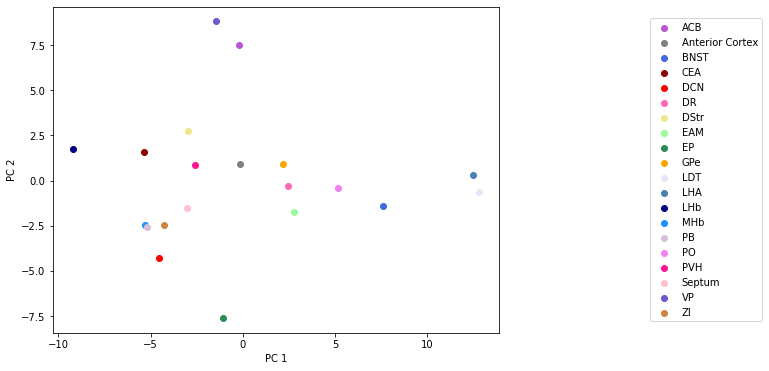

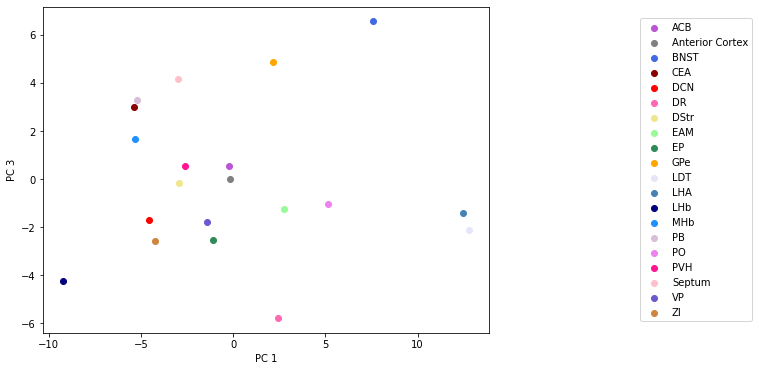

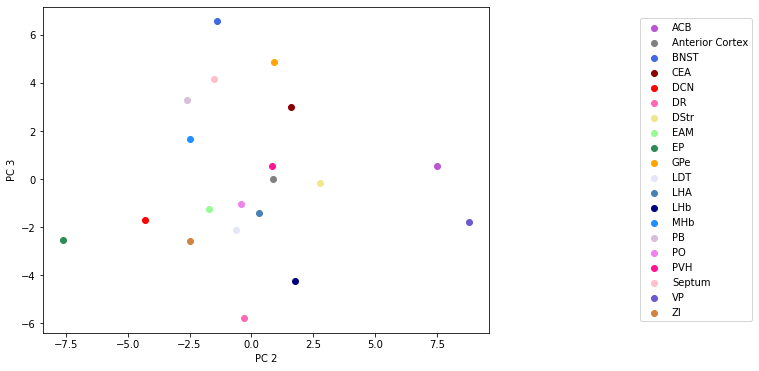

In [37]:
pc1=principalDf['principal component 1']
pc2=principalDf['principal component 2']
pc3=principalDf['principal component 3']
make_pca_plots(pc1,pc2,pc3,labels)
#plot_components(region_components,condition_nums)

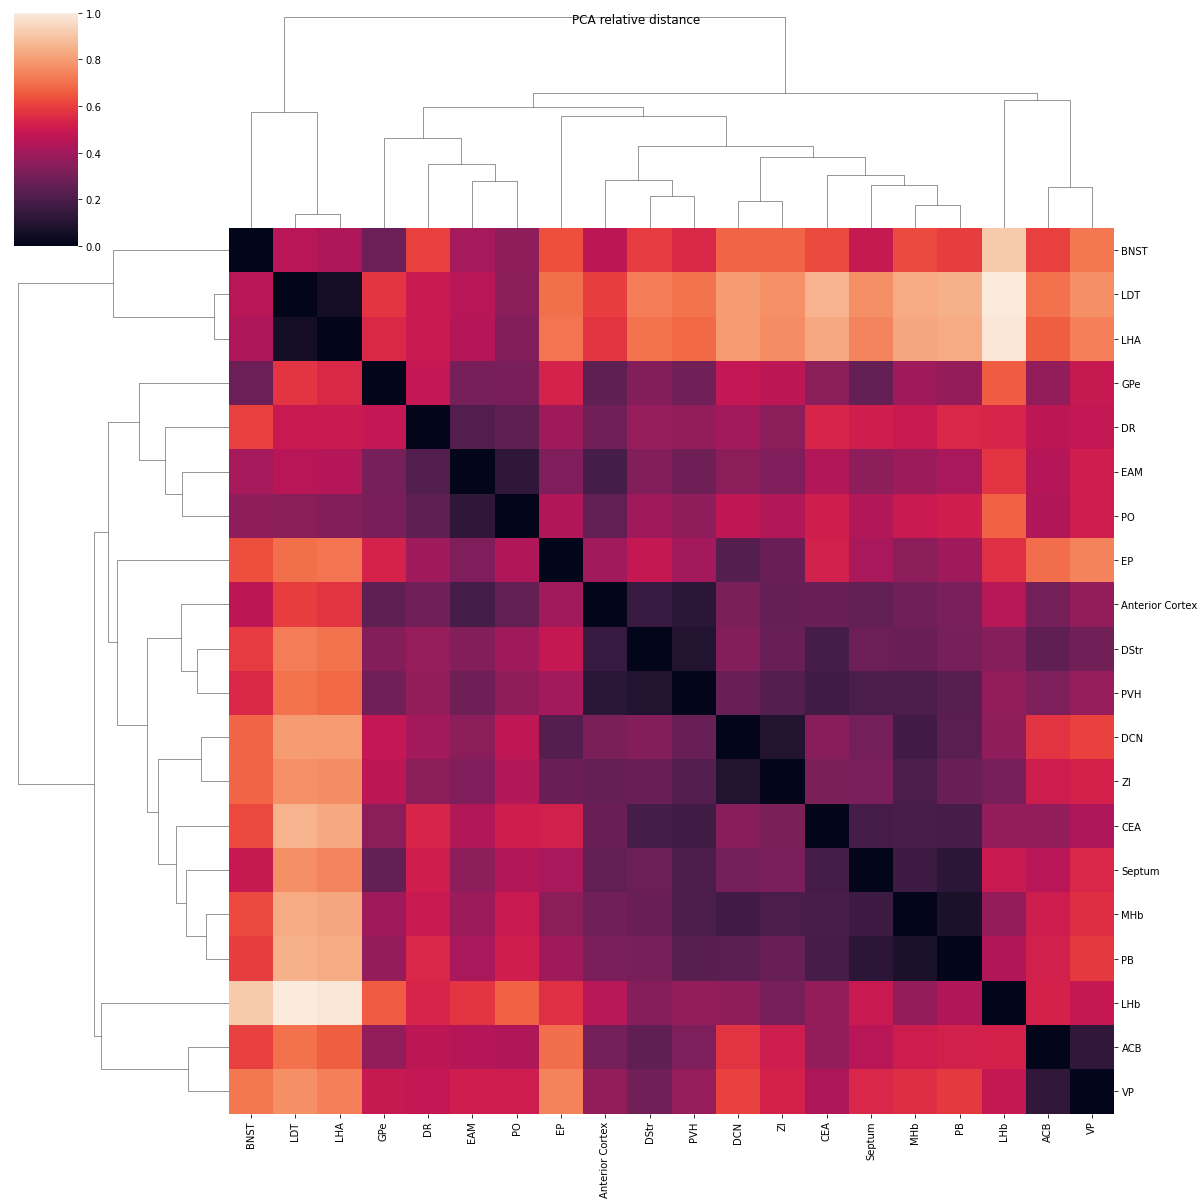

In [38]:
pca_dist=pca_distance(pc1,pc2,pc3,labels)
heatmapdf = pd.DataFrame(pca_dist,index=labels,columns=labels)
cm = sns.clustermap(heatmapdf,yticklabels=True)
cm.fig.suptitle("PCA relative distance")
cm.fig.set_size_inches(18, 18)

# UMAP

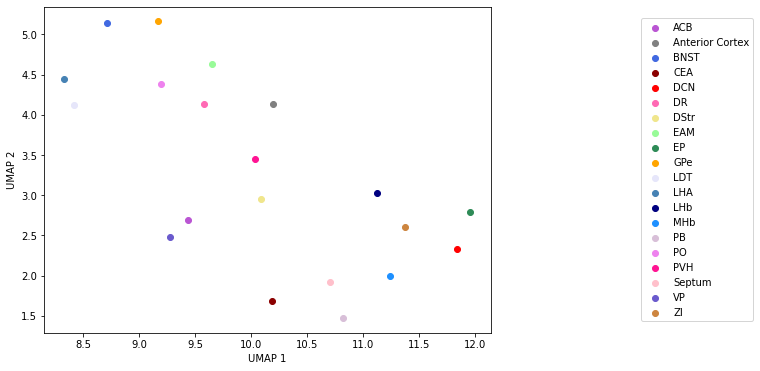

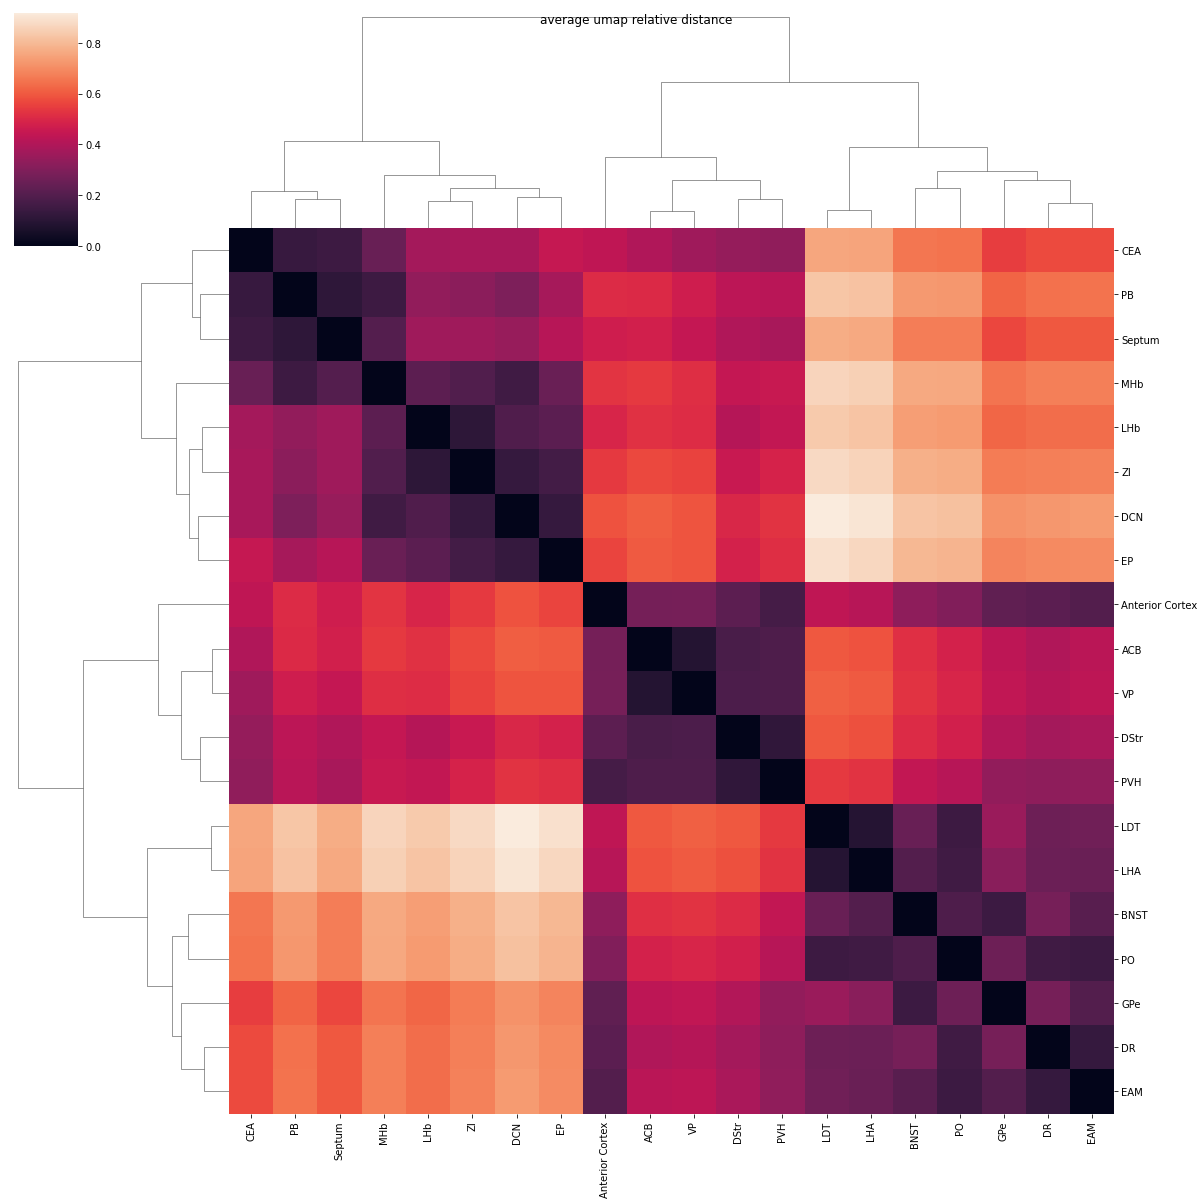

In [39]:
umap_plot(X_scaled,labels)

# Calcium channels genes only

In [40]:
dat2
calc_genes=['Cacna1s',
 'Cacna1c',
 'Cacna1d',
 'Cacna1f',
 'Cacna1a',
 'Cacna1b',
 'Cacna1e',
 'Cacna1g',
 'Cacna1h',
 'Cacna1i',
 'Cacna1s',
 'Cacna1c',
 'Cacna1d',
 'Cacna1f',
 'Cacna1a',
 'Cacna1b',
 'Cacna1e',
 'Cacna1g',
 'Cacna1h',
 'Cacna1i'] # Cacna1e, Cacna1g, Cacna1h, Cacna1i

#calc_genes=['Glra1', 'Glra2', 'Glra3', 'Glra4', 'Glrb']
data = dat2[dat2.columns.intersection(calc_genes)] 
data

,Cacna1e,Cacna1g,Cacna1h,Cacna1i
brain_region,,,,
ACB,0.838734,0.217533,0.803908,0.544466
Anterior Cortex,0.608057,0.444957,0.585853,0.482467
BNST,0.782020,0.696045,0.774253,0.417868
CEA,0.697591,0.501283,0.572935,0.356320
DCN,0.466413,0.484086,0.390217,0.368814
DR,0.406704,0.354037,0.419351,0.617183
DStr,0.535628,0.285976,0.651251,0.420641
EAM,0.655385,0.534529,0.582622,0.532701
EP,0.479005,0.449723,0.543921,0.341590


In [41]:
features=data.values
regions=list(data.columns)
X1=features.astype(float)
X_scaled=X1 #this is already scaled!! no need to zscore
labels=list(data.index)

# PCA

In [42]:
#can change n_components to more if you want to visualize in 3D 
pca = PCA(n_components=3)
#PCA using the scaled drug data array made earlier
principalComponents = pca.fit_transform(X_scaled)
#make into dataframe if you want to view with labels
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
region_components=pd.DataFrame(data = pca.components_ , columns = regions)
#view df
print('Explained variance for each PC: 1, 2, 3')
print(pca.explained_variance_)
principalDf

Explained variance for each PC: 1, 2, 3
[0.05231646 0.02179923 0.01539018]


,principal component 1,principal component 2,principal component 3
0,-0.311398,0.227927,-0.122531
1,-0.018549,-0.009967,-0.012433
2,-0.254602,-0.244993,-0.116352
3,-0.037834,-0.110016,-0.132928
4,0.232935,-0.094469,-0.015782
5,0.184560,0.102175,0.187942
6,0.036009,0.149692,-0.101973
7,-0.078516,-0.089741,0.040602
8,0.150365,-0.036478,-0.094906
9,-0.052994,0.026608,-0.157341


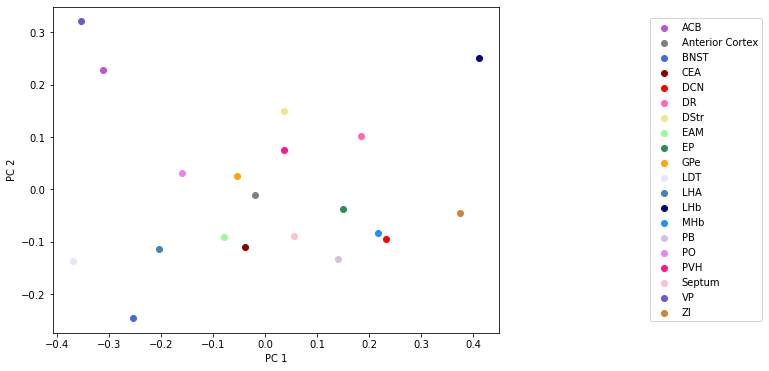

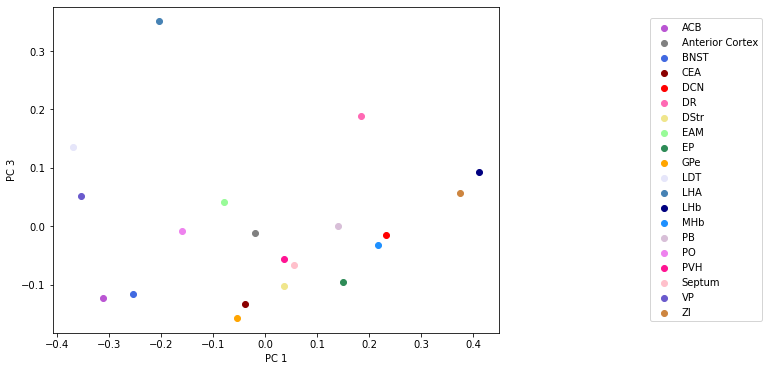

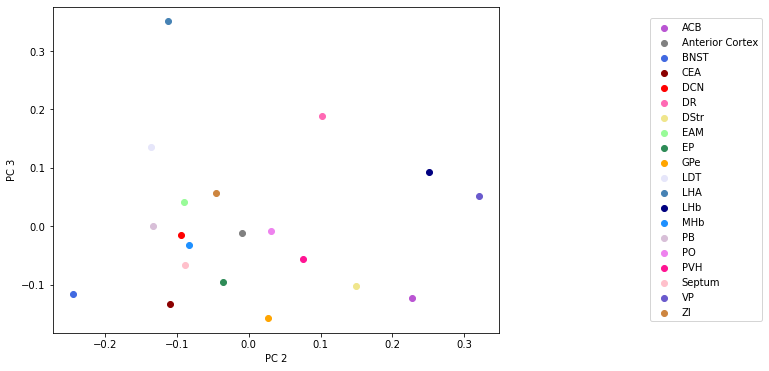

In [43]:
pc1=principalDf['principal component 1']
pc2=principalDf['principal component 2']
pc3=principalDf['principal component 3']
make_pca_plots(pc1,pc2,pc3,labels)
#plot_components(region_components,condition_nums)

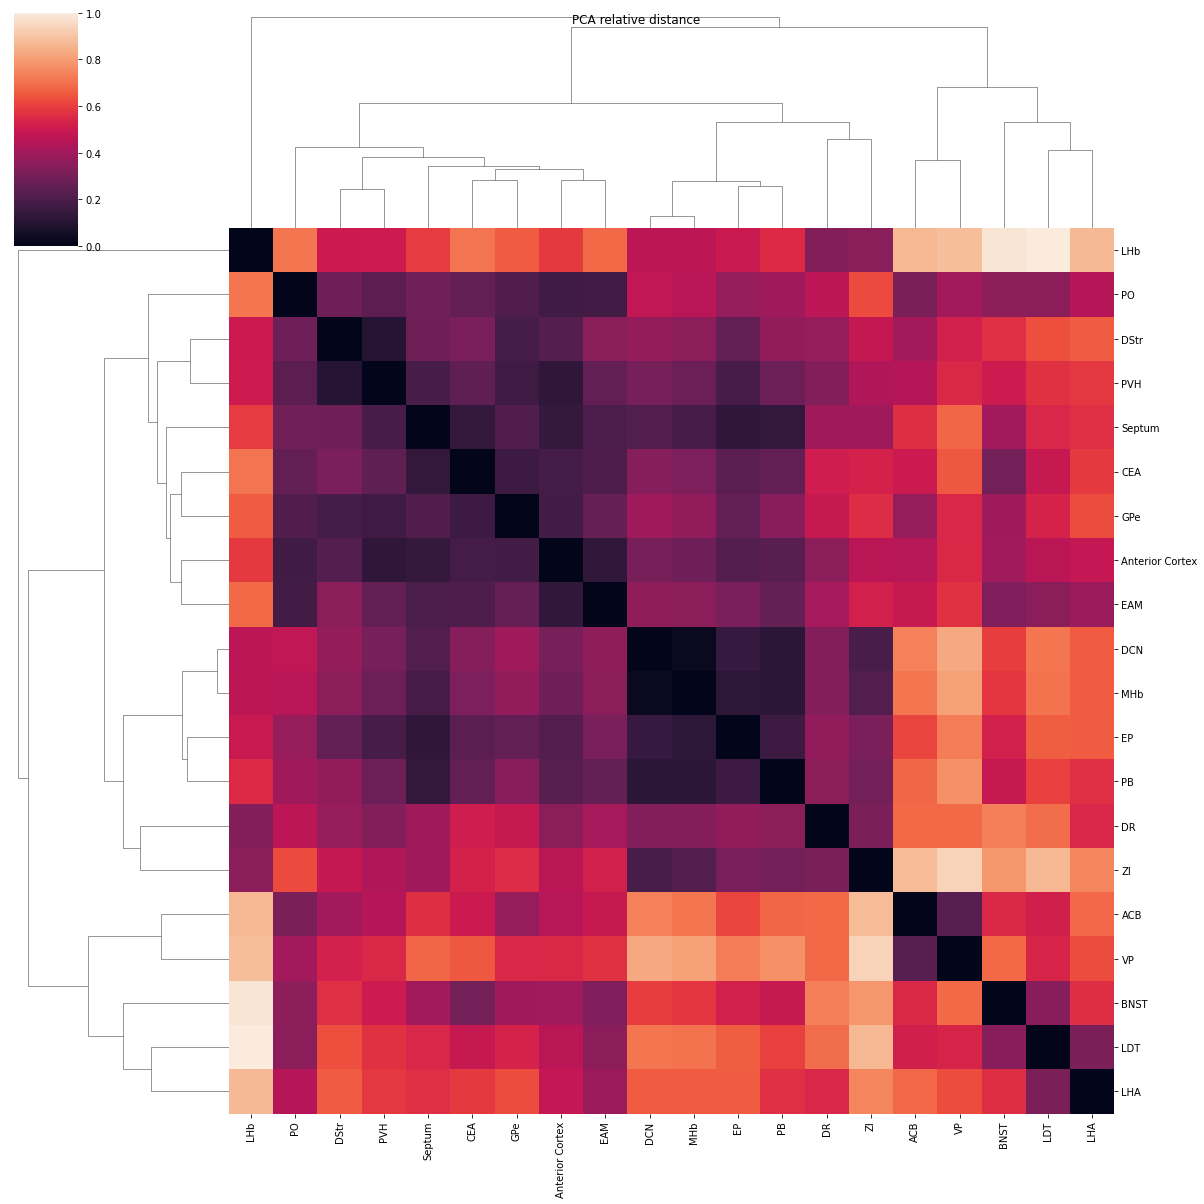

In [44]:
pca_dist=pca_distance(pc1,pc2,pc3,labels)
heatmapdf = pd.DataFrame(pca_dist,index=labels,columns=labels)
cm = sns.clustermap(heatmapdf,yticklabels=True)
cm.fig.suptitle("PCA relative distance")
cm.fig.set_size_inches(18, 18)

# UMAP

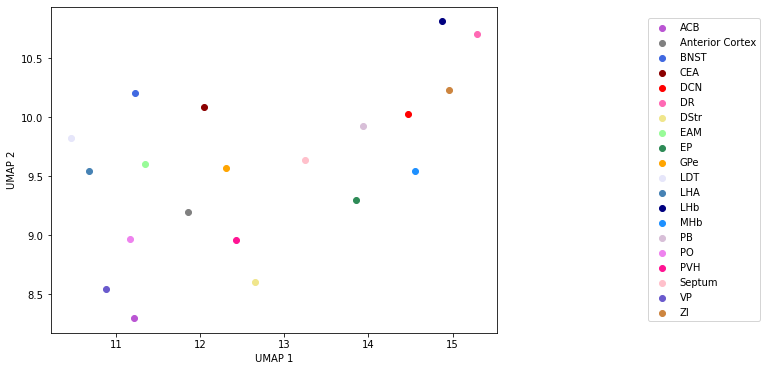

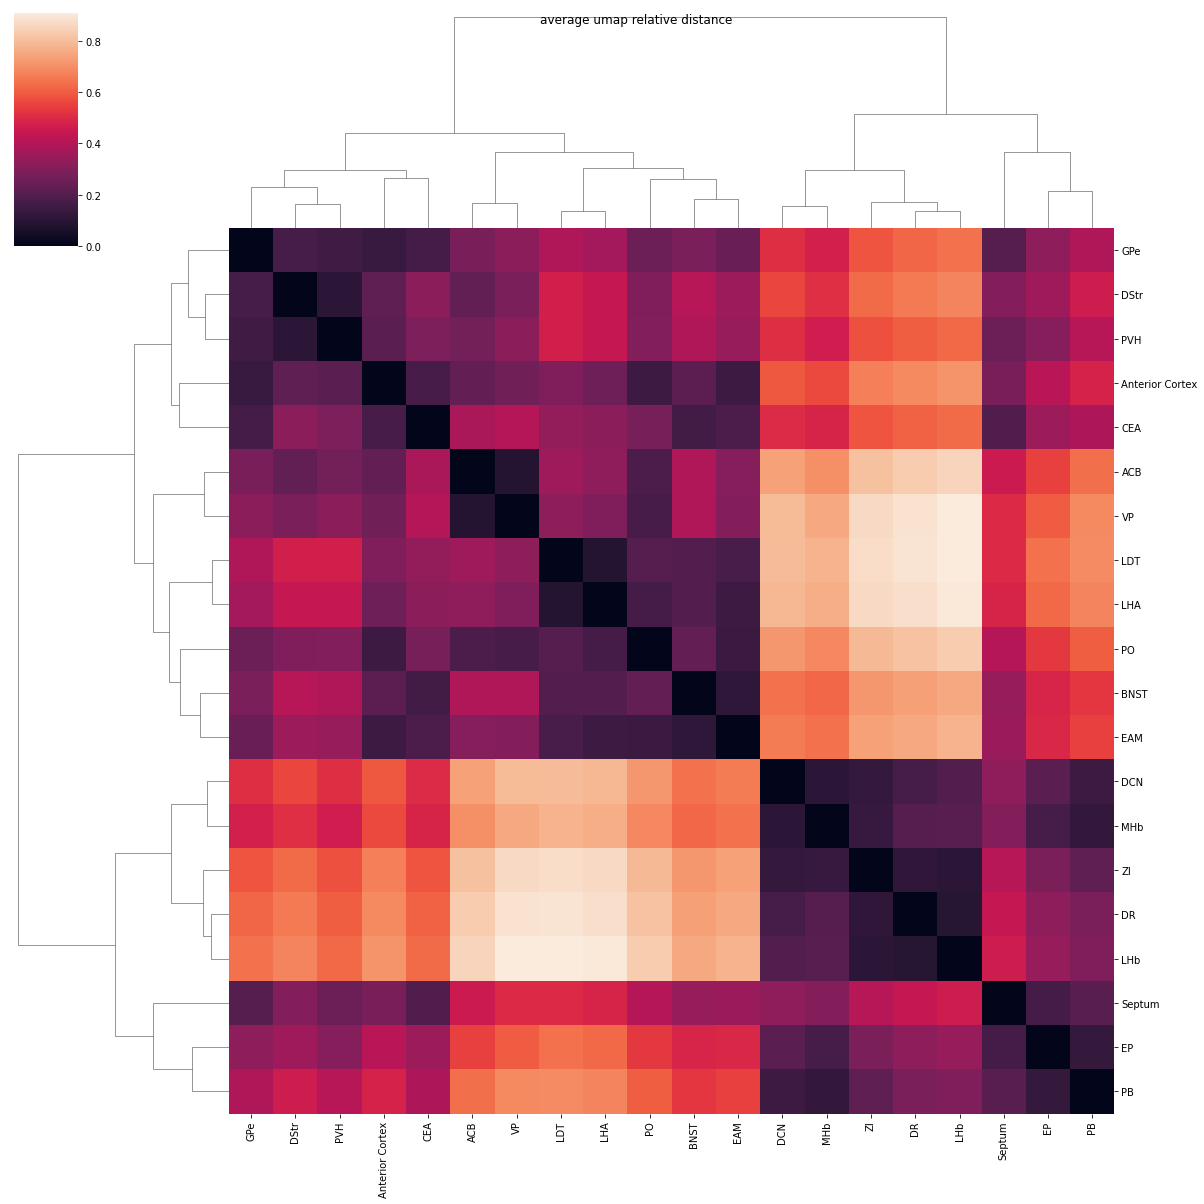

In [45]:
umap_plot(X_scaled,labels)

# Glycine-receptor channels genes only

In [46]:
dat2

calc_genes=['Glra1', 'Glra2', 'Glra3', 'Glra4', 'Glrb']
data = dat2[dat2.columns.intersection(calc_genes)] 
data

,Glra1,Glra2,Glra3,Glra4,Glrb
brain_region,,,,,
ACB,0.358319,0.486976,0.328836,0.366797,0.318338
Anterior Cortex,0.367911,0.597993,0.500862,0.381136,0.422356
BNST,0.358409,0.612884,0.875662,0.388544,0.522908
CEA,0.367903,0.735557,0.580069,0.362038,0.253089
DCN,0.574795,0.712243,0.833323,0.449172,0.633090
DR,0.431062,0.351259,0.350551,0.419343,0.618644
DStr,0.364752,0.428819,0.456449,0.370656,0.390380
EAM,0.439796,0.570585,0.556349,0.436061,0.538811
EP,0.678919,0.851505,0.701354,0.432311,0.602714


In [47]:
features=data.values
regions=list(data.columns)
X1=features.astype(float)
X_scaled=X1 #this is already scaled!! no need to zscore
labels=list(data.index)

# PCA

In [48]:
#can change n_components to more if you want to visualize in 3D 
pca = PCA(n_components=3)
#PCA using the scaled drug data array made earlier
principalComponents = pca.fit_transform(X_scaled)
#make into dataframe if you want to view with labels
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
region_components=pd.DataFrame(data = pca.components_ , columns = regions)
#view df
print('Explained variance for each PC: 1, 2, 3')
print(pca.explained_variance_)
principalDf

Explained variance for each PC: 1, 2, 3
[0.05211989 0.02395206 0.01001084]


,principal component 1,principal component 2,principal component 3
0,-0.225400,-0.145819,-0.062823
1,-0.027240,-0.041685,-0.039884
2,0.261585,0.084913,0.185821
3,0.126635,-0.211418,-0.075566
4,0.320035,0.243955,0.012297
5,-0.295680,0.181858,0.004386
6,-0.167254,-0.056293,0.052905
7,0.004699,0.104395,-0.016334
8,0.322994,0.214401,-0.200368
9,0.256940,-0.041764,0.260087


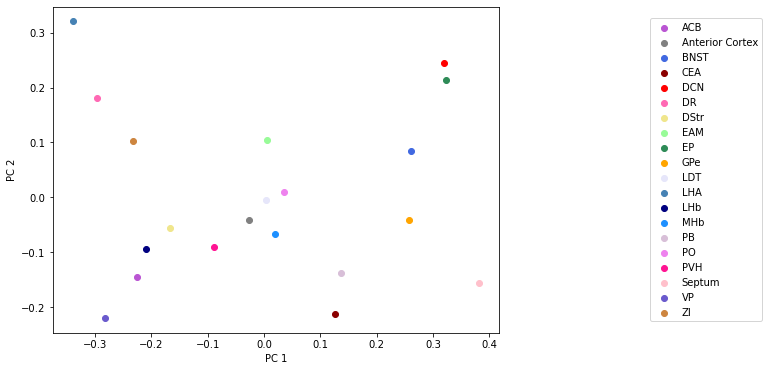

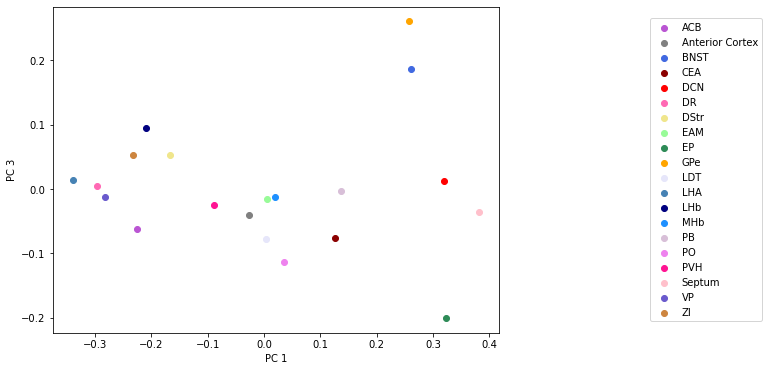

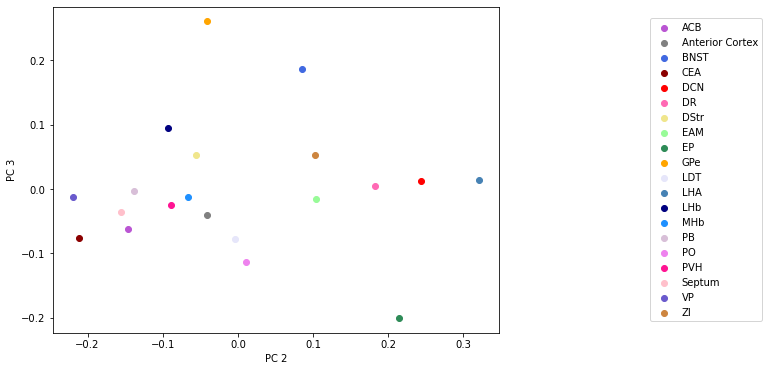

In [49]:
pc1=principalDf['principal component 1']
pc2=principalDf['principal component 2']
pc3=principalDf['principal component 3']
make_pca_plots(pc1,pc2,pc3,labels)
#plot_components(region_components,condition_nums)

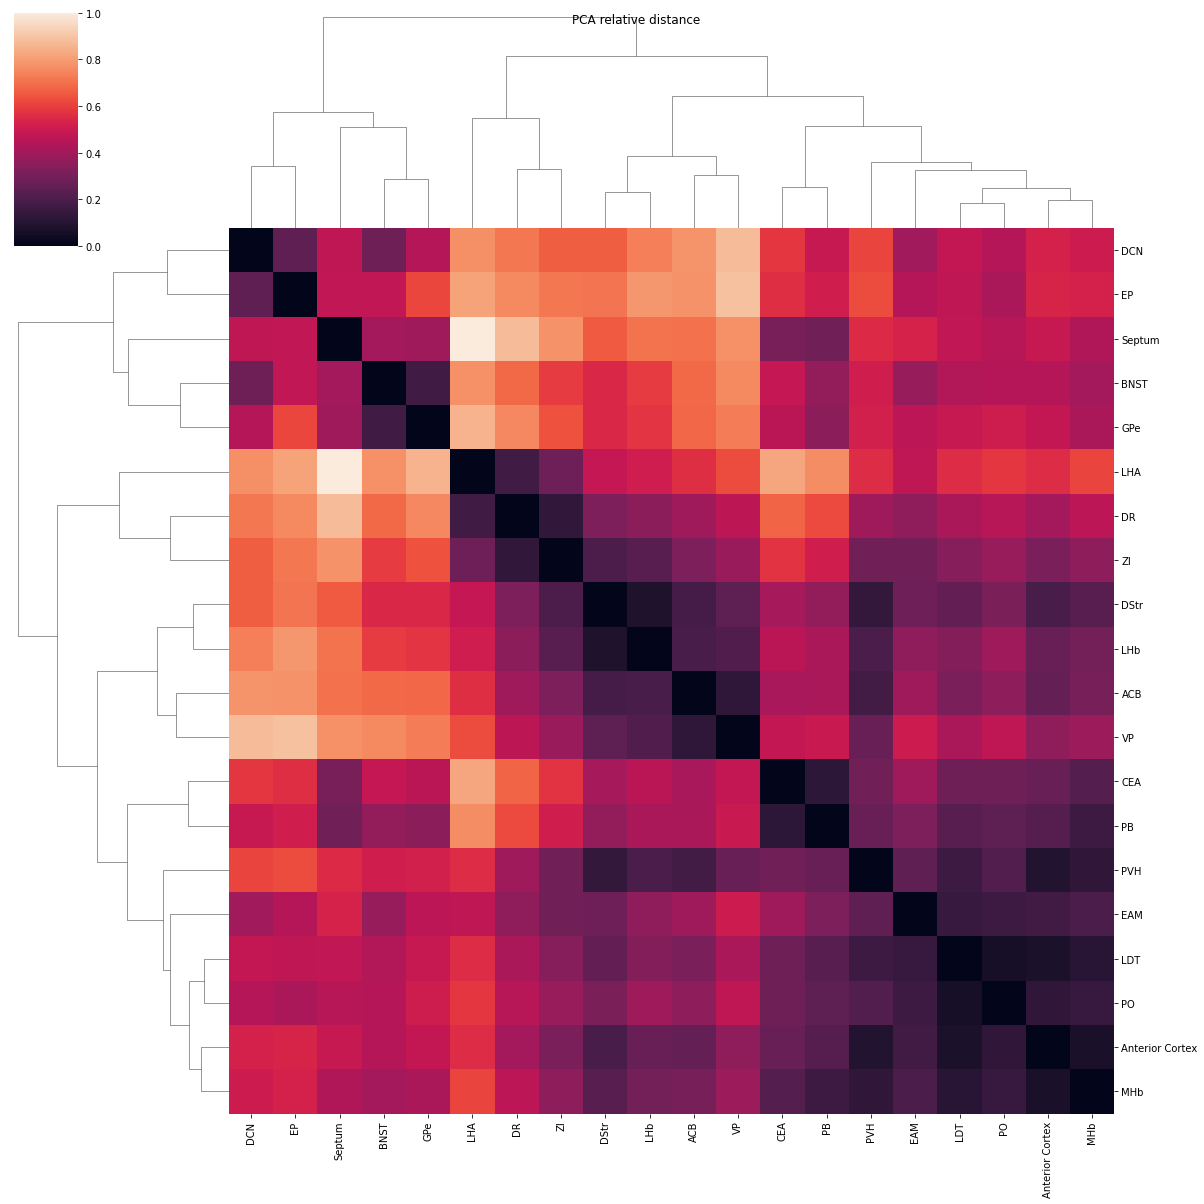

In [50]:
pca_dist=pca_distance(pc1,pc2,pc3,labels)
heatmapdf = pd.DataFrame(pca_dist,index=labels,columns=labels)
cm = sns.clustermap(heatmapdf,yticklabels=True)
cm.fig.suptitle("PCA relative distance")
cm.fig.set_size_inches(18, 18)

# UMAP

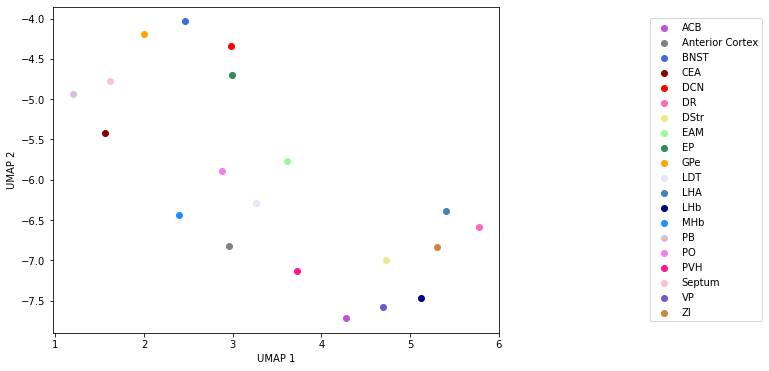

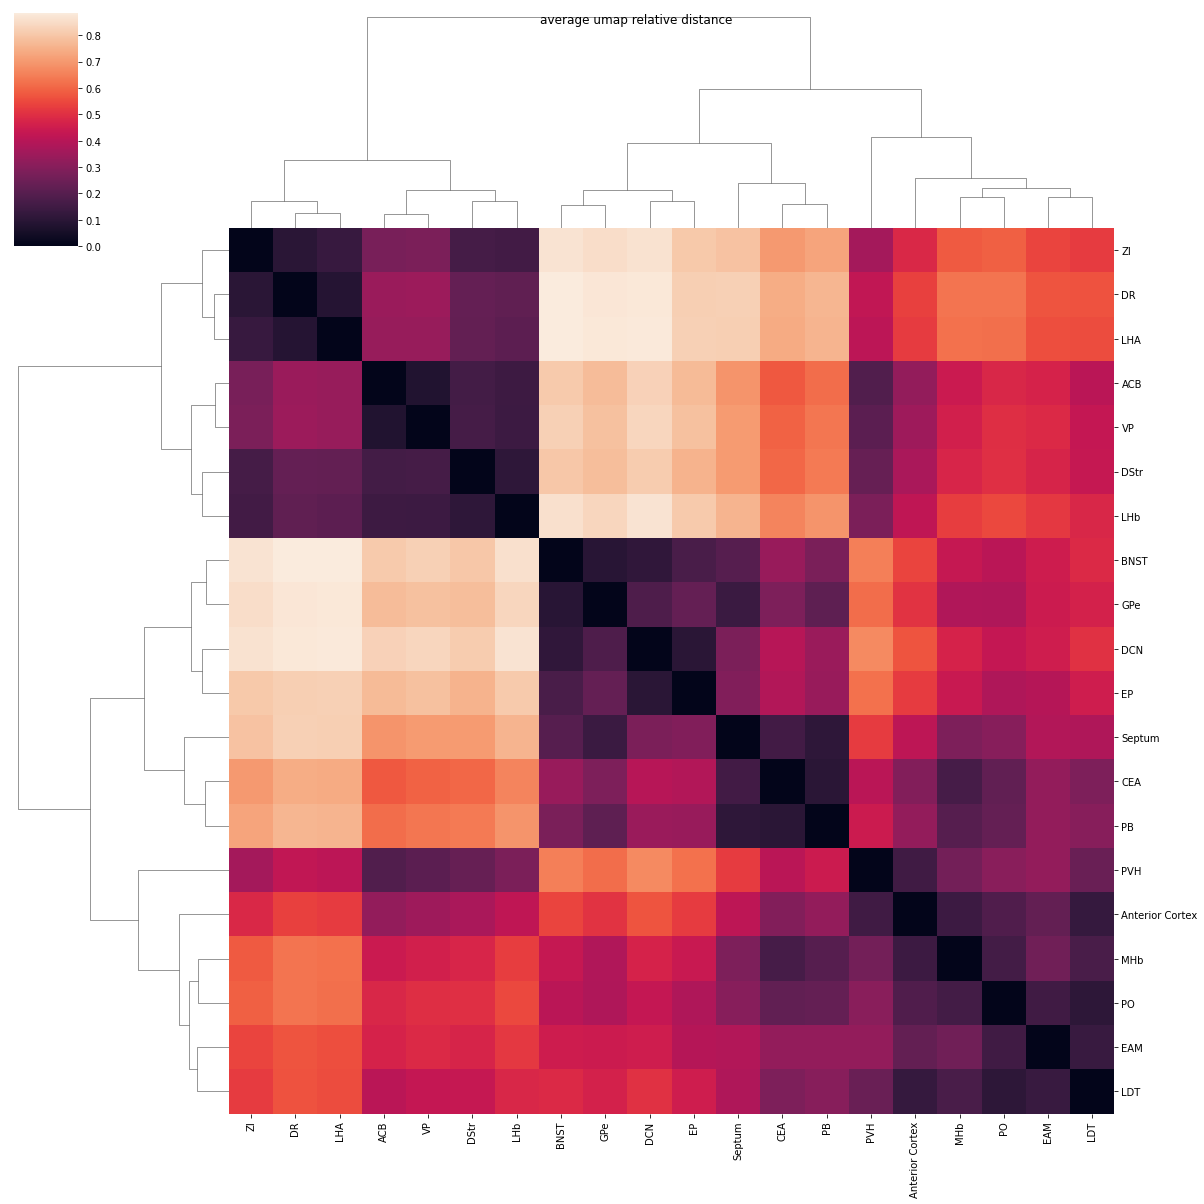

In [51]:
umap_plot(X_scaled,labels)